## hardware

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7452 32-Core Processor
stepping	: 0
microcode	: 0x830107a
cpu MHz		: 1500.000
cache size	: 512 KB
physical id	: 0
siblings	: 64
core id		: 0
cpu cores	: 32
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 16
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid aperfmperf rapl pni pclmulqdq monitor ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw ibs skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb cat_l3 cdp_l3 hw_pstate ssbd mba ibrs ibpb stibp vmmcall fsgsbase bmi1 avx2 smep bmi2 cqm rdt_a rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 cqm_llc cqm_occup_llc cqm_

In [2]:
!nvidia-smi

Mon Sep 30 15:24:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.76                 Driver Version: 550.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:C2:00.0 Off |                  N/A |
| 50%   51C    P8             27W /  350W |       1MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## kaggle

In [3]:
# import os

# if not os.path.isdir('/content/train_images/'):
#     #!mkdir -p ~/.kaggle
#     #!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
#     #!chmod 600 ~/.kaggle/kaggle.json

#     #!kaggle competitions download -c rsna-2024-lumbar-spine-degenerative-classification -p '/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/DataSources/'

#     !unzip '/content/drive/MyDrive/Kaggle/RSNA 2024 Lumbar Spine Degenerative Classification/DataSources/rsna-2024-lumbar-spine-degenerative-classification.zip'

## library

In [4]:
!pip install albumentations pydicom segmentation_models_pytorch timm transformers

In [5]:
import numpy as np
import pandas as pd

import random

import os

import glob

from tqdm import tqdm

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import cv2

import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A

import pydicom

import timm

from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import RobertaPreLayerNormConfig, RobertaPreLayerNormModel

from scipy.ndimage import gaussian_filter

from segmentation_models_pytorch.decoders.unet.model import (
    UnetDecoder,
    SegmentationHead,
)
DATA_DIR = '/sys/fs/cgroup/data'

## config

In [6]:
class CustomConfig:
    seed = 42
    device = 'cuda'
    root = DATA_DIR

    train = pd.read_csv(f'{DATA_DIR}/train.csv')
    label_columns = train.columns[1:]

    ignore_index = -100
    label2index = {'Normal/Mild' : 0, 'Moderate' : 1, 'Severe' : 2, 'Nan' : ignore_index,}
    label2onehot = {'Normal/Mild' : [1, 0, 0], 'Moderate' : [0, 1, 0], 'Severe' : [0, 0, 1], 'Nan' : [ignore_index] * 3,}
    label2weight = {'Normal/Mild' : 1, 'Moderate' : 2, 'Severe' : 4, 'Nan' : 0,}

    scan_orientations = ['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2']

    n_class = 3
    n_fold = 5

    batch_size = 4
    n_worker = 16

    lr = 1e-4
    wd = 1e-2
    n_epoch = 20
    warmup_ratio = 0.1
    test_freq = 1

    mix_method = 'cutmix'
    mix_prob = 0.5
    mix_alpha = 1.0

    coordinate_columns = {
        'Sagittal T2/STIR' : [
            ['Spinal Canal Stenosis', 'L1/L2'],
            ['Spinal Canal Stenosis', 'L2/L3'],
            ['Spinal Canal Stenosis', 'L3/L4'],
            ['Spinal Canal Stenosis', 'L4/L5'],
            ['Spinal Canal Stenosis', 'L5/S1'],
        ],
        'Sagittal T1' : [
            ['Left Neural Foraminal Narrowing', 'L1/L2'],
            ['Left Neural Foraminal Narrowing', 'L2/L3'],
            ['Left Neural Foraminal Narrowing', 'L3/L4'],
            ['Left Neural Foraminal Narrowing', 'L4/L5'],
            ['Left Neural Foraminal Narrowing', 'L5/S1'],

            ['Right Neural Foraminal Narrowing', 'L1/L2'],
            ['Right Neural Foraminal Narrowing', 'L2/L3'],
            ['Right Neural Foraminal Narrowing', 'L3/L4'],
            ['Right Neural Foraminal Narrowing', 'L4/L5'],
            ['Right Neural Foraminal Narrowing', 'L5/S1'],
        ],
        'Axial T2' : [
            ['Left Subarticular Stenosis', 'L1/L2'],
            ['Left Subarticular Stenosis', 'L2/L3'],
            ['Left Subarticular Stenosis', 'L3/L4'],
            ['Left Subarticular Stenosis', 'L4/L5'],
            ['Left Subarticular Stenosis', 'L5/S1'],

            ['Right Subarticular Stenosis', 'L1/L2'],
            ['Right Subarticular Stenosis', 'L2/L3'],
            ['Right Subarticular Stenosis', 'L3/L4'],
            ['Right Subarticular Stenosis', 'L4/L5'],
            ['Right Subarticular Stenosis', 'L5/S1'],
        ],
    }

if __name__ == "__main__":
    args = CustomConfig()

## seed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

if __name__ == "__main__":
    seed_everything(args.seed)

## preprocess

In [8]:
def preprocess(args):
    train = pd.read_csv(f'{DATA_DIR}/train.csv')

    folds = []

    kf = KFold(n_splits = args.n_fold, shuffle = True, random_state = args.seed)
    for train_indices, test_indices in kf.split(train):

        train_df = train.loc[train_indices].reset_index(drop = True)
        test_df = train.loc[test_indices].reset_index(drop = True)

        folds.append([train_df, test_df])

    return train, folds

if __name__ == "__main__":
    train, folds = preprocess(args)

## utils

In [9]:
def volume2point(volumes):
    volumes = volumes.cpu()

    batch_size, n_class, _, h, w = volumes.shape

    points = []
    for i in range(batch_size):
        volume = volumes[i]

        point = []
        for j in range(n_class):
            flat_volume = volume[j].reshape(-1)
            max_idx = torch.argmax(flat_volume)

            z = max_idx // (h * w)
            y = (max_idx % (h * w)) // w
            x = (max_idx % (h * w)) % w
            point.append(torch.stack([z, y, x]))

        point = torch.stack(point, dim = 0)
        points.append(point)

    points = torch.stack(points, dim = 0)
    return points.numpy()



def volume2point2(volumes):
    volumes = volumes.cpu()

    batch_size, n_class, _, h, w = volumes.shape

    points = []
    for i in range(batch_size):
        volume = volumes[i]

        point = []
        for j in range(n_class):
            flat_volume = volume[j].reshape(-1)
            max_idx = torch.argmax(flat_volume)

            max_idxs = []
            for k in [-9, -7, -5, -3, -1, 1, 3, 5, 7]:
                idx_start = max_idx + k*(h*w)//2
                idx_start = max(0, idx_start)
                idx_start = min(idx_start, flat_volume.shape[0]-h*w)
                max_idxs.append(idx_start + torch.argmax(flat_volume[idx_start:idx_start + h*w]))

            z = max_idx // (h * w)
            y = [(idx % (h * w)) // w for idx in max_idxs]
            x = [(idx % (h * w)) % w for idx in max_idxs]
            point.append(torch.stack([z] +  y + x))

        point = torch.stack(point, dim = 0)
        points.append(point)

    points = torch.stack(points, dim = 0)
    return points.numpy()

## dataset

In [10]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x)
    return (x * 255).astype("uint8")

def get_imgs(dcms):
    imgs = []
    for dcm in dcms:
        img = convert_to_8bit(dcm.pixel_array)
        imgs.append(img)

    try:
        return np.stack(imgs, axis = 0)
    except:
        h, w = imgs[0].shape
        imgs = [A.Resize(h, w)(image = x)['image'] for x in imgs]
        return np.stack(imgs, axis = 0)

inputs :  torch.Size([29, 256, 256])
targets :  torch.Size([5, 29, 256, 256])
masks :  torch.Size([5, 29])
[[[ 11 106 146]
  [ 11 128 135]
  [ 11 148 132]
  [ 11 169 142]
  [ 11 183 154]]]


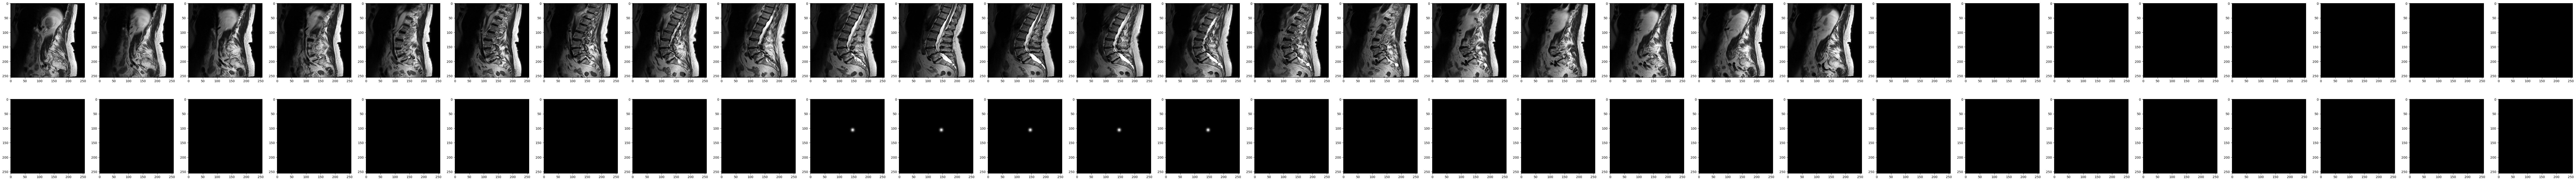

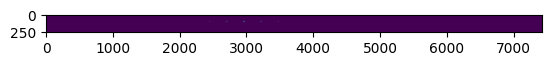

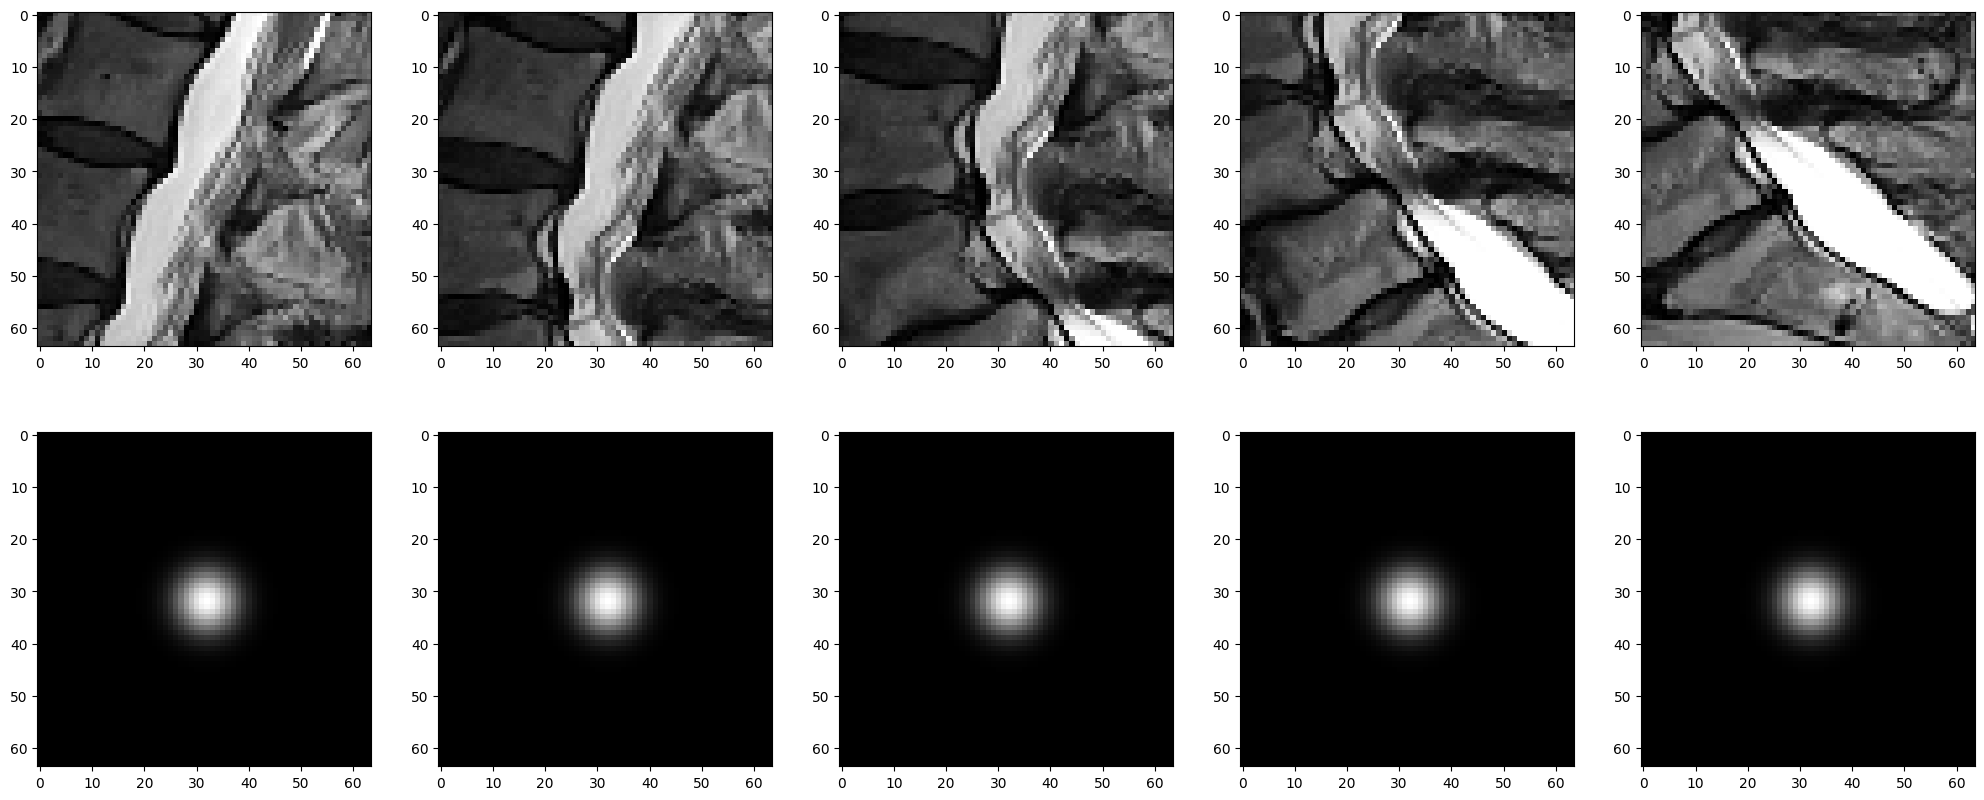

In [11]:
class DetectDataset(torch.utils.data.Dataset):
    def __init__(self, args, df, orientation):
        self.args = args
        self.df = df
        self.orientation = orientation

        self.volume_size = {
            'Sagittal T2/STIR' : [29, 256, 256],
            'Sagittal T1' : [38, 256, 256],
            'Axial T2' : [192, 256, 256]
        }[orientation]

        self.train_series_descriptions = pd.read_csv(f'{DATA_DIR}/train_series_descriptions.csv')
        # self.train_label_coordinates = pd.read_csv(f'{DATA_DIR}/train_label_coordinates.csv')
        self.train_label_coordinates = pd.read_csv(f'{DATA_DIR}/coords_rsna_improved.csv')

    

    def __len__(self):
        return len(self.df)

    def get_subvolume(self, study_id, series_id):
        dicoms = sorted(glob.glob(self.args.root + f'/train_images/{study_id}/{series_id}/*.dcm'), key = lambda x: int(x.split('/')[-1].split('.')[0]))     
        dicoms = [pydicom.dcmread(x) for x in dicoms]
        
        if 'Sagittal' in self.orientation:
            pos = np.asarray([dicom.ImagePositionPatient for dicom in dicoms])[:, 0]
        else:
            pos = np.asarray([dicom.ImagePositionPatient for dicom in dicoms])[:, -1]
            orien = np.asarray([dicom.ImageOrientationPatient for dicom in dicoms])


        inputs = get_imgs(dicoms)
        inputs = A.Resize(self.volume_size[1], self.volume_size[2])(image = inputs.transpose(1, 2, 0))['image'].transpose(2, 0, 1)
        inputs = torch.tensor(inputs, dtype = torch.float)
        inputs = inputs / 255.0

        return inputs, pos

    def get_inputs(self, row):
        row_series_descriptions = self.train_series_descriptions[self.train_series_descriptions['study_id'] == row['study_id']]
        row_series_descriptions = row_series_descriptions[row_series_descriptions['series_description'] == self.orientation].reset_index(drop = True)
        
        
        if len(row_series_descriptions) > 0:
            inputs, pos = [], []
            for i in range(len(row_series_descriptions)):
                study_id, series_id, _ = row_series_descriptions.loc[i]
                
                _inputs, _pos = self.get_subvolume(study_id, series_id)
                inputs.append(_inputs)
                pos.append(_pos)

            inputs = torch.cat(inputs, dim = 0)
            pos = np.concatenate(pos, axis = 0)
        else:
            inputs = torch.zeros(self.volume_size, dtype = torch.float32)
            pos = np.zeros([self.volume_size[0]], dtype = np.float32)

        return inputs, pos

    def get_targets(self, row, inputs):
        row_series_descriptions = self.train_series_descriptions[self.train_series_descriptions['study_id'] == row['study_id']]
        row_series_descriptions = row_series_descriptions[row_series_descriptions['series_description'] == self.orientation].reset_index(drop = True)
        targets = np.zeros([len(self.args.coordinate_columns[self.orientation])] + [inputs.shape[0]] + self.volume_size[1:], dtype = np.float32)

        if len(row_series_descriptions) > 0:
            dicoms = []
            series_ids = []
            for i in range(len(row_series_descriptions)):
                study_id, series_id, _ = row_series_descriptions.loc[i]

                d = sorted(glob.glob(f'{DATA_DIR}/train_images/{study_id}/{series_id}/*.dcm'), key = lambda x: int(x.split('/')[-1].split('.')[0]))
                series_ids += [series_id]*len(d)
                dicoms += d
            instance_numbers = [int(x.split('/')[-1].split('.')[0]) for x in dicoms]
            instance_serie2index = {(instance_numbers[i], series_ids[i]):i for i in range(len(instance_numbers))}

            for series_id in set(series_ids):
                label_coordinate = self.train_label_coordinates[(self.train_label_coordinates['study_id'] == study_id) & (self.train_label_coordinates['series_id'] == series_id)].reset_index(drop = True)
                for i in range(len(self.args.coordinate_columns[self.orientation])):

                    condition, level = self.args.coordinate_columns[self.orientation][i][0], self.args.coordinate_columns[self.orientation][i][1]
                    try:
                        if self.orientation == 'Sagittal T2/STIR':
                            _, _, x, y, _, _, instance_number, _, _ = label_coordinate[(label_coordinate['condition'] == condition) & (label_coordinate['level'] == level) & (label_coordinate['side'] == 'R')].reset_index(drop = True).loc[0]
                        else:
                            _, _, x, y, _, _, instance_number, _, _ = label_coordinate[(label_coordinate['condition'] == condition) & (label_coordinate['level'] == level)].reset_index(drop = True).loc[0]
                    except:
                        continue;
                    h, w = pydicom.dcmread(f'{DATA_DIR}/train_images/{study_id}/{series_id}/{instance_number}.dcm').pixel_array.shape
                    z = instance_serie2index[(instance_number, series_id)]

                    z_i = z
                    y_i = round(y * (self.volume_size[1]))# / h))
                    x_i = round(x * (self.volume_size[2]))# / w))

                    targets[i, z_i, y_i, x_i] = 1

                    targets[i, z_i] = gaussian_filter(targets[i, z_i], sigma = (4, 4))
                    targets[i, z_i] = targets[i, z_i] / targets[i, z_i].max()

                    targets[i, max(0, z_i - 2)] = targets[i, z_i] / 2**2
                    targets[i, max(0, z_i - 1)] = targets[i, z_i] / 2**1

                    targets[i, min(targets.shape[1] - 1, z_i + 2)] = targets[i, z_i] / 2**2
                    targets[i, min(targets.shape[1] - 1, z_i + 1)] = targets[i, z_i] / 2**1

        targets = torch.tensor(targets, dtype = torch.float)
        return targets

    def get_masks(self, inputs, targets):
        temporal_masks = (inputs.sum(dim = [1, 2]) != 0).float()
        spatial_masks = (targets.sum(dim = [1, 2, 3]) != 0).float()

        masks = temporal_masks[None, :] * spatial_masks[:, None]
        return masks

    def __getitem__(self, index):
        row = self.df.loc[index]
        inputs, pos = self.get_inputs(row)
        targets = self.get_targets(row, inputs)

        pos = np.argsort(pos)

        inputs = inputs[pos]
        targets = targets[:, pos]

        if inputs.shape[0] > self.volume_size[0]:
            inputs = F.interpolate(inputs.unsqueeze(0).unsqueeze(0), size = self.volume_size, mode = 'trilinear').squeeze(0).squeeze(0)
            targets = F.interpolate(targets.unsqueeze(0), size = self.volume_size, mode = 'trilinear').squeeze(0)

        
        inputs = torch.cat([inputs, torch.zeros([self.volume_size[0] - inputs.shape[0]] + list(inputs.shape[1:]), dtype = torch.float)], dim = 0)
        targets = torch.cat([targets, torch.zeros([len(self.args.coordinate_columns[self.orientation])] + [self.volume_size[0] - targets.shape[1]] + list(inputs.shape[1:]), dtype = torch.float)], dim = 1)

        
        masks = self.get_masks(inputs, targets)
        return inputs, targets, masks

if __name__ == "__main__":
    train_df, test_df = folds[0]
    orientation = 'Sagittal T2/STIR'

    dataset = DetectDataset(args, train_df, orientation = orientation)

    index = random.randint(0, len(dataset) - 1)
    inputs, targets, masks = dataset[index]

    print('inputs : ', inputs.shape)
    print('targets : ', targets.shape)
    print('masks : ', masks.shape)

    print(volume2point(targets[None]))

    fig, axes = plt.subplots(2, targets[0].shape[0], figsize = (5 * targets[0].shape[0], 5 * 2))
    for i in range(targets[0].shape[0]):
        axes[0, i].imshow(inputs[i], cmap = 'gray')
        axes[1, i].imshow(targets[0][i], cmap = 'gray')
    plt.show()
    plt.imshow(targets[0].permute(1, 0, 2).reshape(256, -1))
    plt.show()

    patch_size = {'Sagittal T2/STIR' : 32, 'Sagittal T1' : 32, 'Axial T2' : 32}[orientation]
    fig, axes = plt.subplots(2, targets.shape[0], figsize = (5 * targets.shape[0], 5 * 2))

    points = volume2point(targets[None])[0]
    for i in range(targets.shape[0]):
        z, y, x = points[i]
        if points[i].sum() != 0:
            axes[0, i].imshow(inputs[z, y-patch_size:y+patch_size, x-patch_size:x+patch_size], cmap = 'gray')
            axes[1, i].imshow(targets[i][z, y-patch_size:y+patch_size, x-patch_size:x+patch_size], cmap = 'gray')
    plt.show()

## model

In [12]:
class Segmenter(nn.Module):
    def __init__(self,
                 n_class,
                 n_channel,
                 volume_size,
                 backbone = 'tf_efficientnet_b5_ns',
                 n_blocks = 4,
                 ):
        super(Segmenter, self).__init__()

        
        self.n_class = n_class
        self.n_channel = n_channel
        self.volume_size = volume_size

        self.extracter = timm.create_model(backbone, 
                              pretrained=True,
                              features_only = True,
                              out_indices=range(n_blocks),
                                      )

        encoder_channels = [n_channel] + [self.extracter.feature_info[i]["num_chs"] for i in range(n_blocks)]
        decoder_channels = [256, 128, 64, 32, 16, 8][:n_blocks]

        self.decoder = UnetDecoder(
            encoder_channels = encoder_channels,
            decoder_channels = decoder_channels,
            n_blocks = n_blocks,
            use_batchnorm = True,
            center = False,
            attention_type = None,
        )

        self.head = SegmentationHead(
            in_channels = decoder_channels[-1],
            out_channels = self.n_class,
            activation = None,
            kernel_size= 3,
        )

    def forward(self, x):
        x = x.reshape(-1, self.n_channel, self.volume_size[1], self.volume_size[2])
        _x = self.extracter(x)

        x = self.decoder(*[x] + _x)
        x = self.head(x)

        x = x.reshape(-1, self.volume_size[0], self.n_class, self.volume_size[1], self.volume_size[2])
        x = x.permute(0, 2, 1, 3, 4)
        return x

In [13]:
class Pointer(nn.Module):
    def __init__(self,
                 n_class,
                 n_channel,
                 volume_size,
                 hidden_size,
                 drop_rate,
                 is_lstm = True,
                 ):
        super(Pointer, self).__init__()

        self.n_channel = n_channel
        self.volume_size = volume_size
        


        self.is_lstm = is_lstm


        if self.is_lstm:
    
            self.extractor = timm.create_model('regnety_002', 
                                  pretrained=True,
                                  features_only = True,
                                  in_chans = n_channel,
                                              )
    
            self.dense_size = self.extractor.feature_info[-1]["num_chs"]
            self.rnn = nn.LSTM(
                input_size = self.dense_size,
                hidden_size = hidden_size,
                batch_first = True,
                bidirectional = True
                )
            self.out = nn.Sequential(
                    nn.Dropout(p = drop_rate),
                    nn.Linear(2 * hidden_size, n_class)
                )
        else:
            self.extracter = timm.create_model('regnety_002', 
                                  pretrained=True,
                                  features_only = True,
                                  in_chans = n_channel,
                                              )
    
            self.dense_size = self.extracter.feature_info[-1]["num_chs"]

            self.dense = nn.Linear(self.dense_size, hidden_size)
    
            self.transformer = RobertaPreLayerNormModel(
                RobertaPreLayerNormConfig(
                    hidden_size = hidden_size,
                    num_hidden_layers = 1,
                    num_attention_heads = 4,
                    intermediate_size = 4 * hidden_size,
                    hidden_act = 'gelu',
                    )
                )
            del self.transformer.embeddings.word_embeddings

            self.out = nn.Sequential(
                nn.Dropout(p = drop_rate),
                nn.Linear(hidden_size, n_class)
            )

    def forward(self, x, mask):
        x = x.reshape(-1, self.n_channel, self.volume_size[1], self.volume_size[2])
        if self.is_lstm:
            x = self.extractor(x)
            x = x[-1].mean(dim = [2, 3])
            x = x.reshape(-1, self.volume_size[0], self.dense_size)
            x, _ =  self.rnn(x)
        else:
            x = self.extracter(x)
            x = x[-1].mean(dim = [2, 3])
            x = x.reshape(-1, self.volume_size[0], self.dense_size)
            x = self.dense(x)
            x = self.transformer(inputs_embeds = x, attention_mask = mask).last_hidden_state
        x = self.out(x)

        x = x.permute(0, 2, 1)
        return x




In [14]:
class DetectModel(nn.Module):
    def __init__(self,
                 args,
                 orientation,
                 n_channel = 3,
                 hidden_size = 256,
                 drop_rate = 0.3,                 
                 ):

        super(DetectModel, self).__init__()
        self.args = args

        self.orientation = orientation

        n_class = {
            'Sagittal T2/STIR' : 5,
            'Sagittal T1' : 10,
            'Axial T2' : 10,
        }[orientation]

        volume_size = {
            'Sagittal T2/STIR' : [29, 256, 256],
            'Sagittal T1' : [38, 256, 256],
            'Axial T2' : [192, 256, 256]
        }[orientation]

        segmenter_backbone = {
            'Sagittal T2/STIR' : 'tf_efficientnet_b5_ns',
            'Sagittal T1' :'tf_efficientnet_b5_ns',
            'Axial T2' : 'regnety_002'
        }[orientation]

        n_blocks = {
            'Sagittal T2/STIR' : 4,
            'Sagittal T1' :4,
            'Axial T2' : 5
        }[orientation]

        is_lstm = {
            'Sagittal T2/STIR' : True,
            'Sagittal T1' :True,
            'Axial T2' : False
        }[orientation]

        self.n_channel = n_channel
        self.volume_size = volume_size

        self.segmenter = Segmenter(
            n_class = n_class,
            n_channel = n_channel,
            volume_size = volume_size,
            backbone = segmenter_backbone,
            n_blocks = n_blocks,
            )

        self.pointer = Pointer(
            n_class = n_class,
            n_channel = n_channel,
            volume_size = volume_size,
            hidden_size = hidden_size,
            drop_rate = drop_rate,
            is_lstm = is_lstm,
        )

    def get_inputs(self, x):
        x = F.pad(x, (0, 0, 0, 0, (self.n_channel-1)//2, (self.n_channel-1)//2), "constant", 0)
        x = [x[:, i:i+self.n_channel] for i in range(self.volume_size[0])]
        x = torch.stack(x, dim = 1)
        return x

    def get_masks(self, x):
        x = (x.sum(dim = [2, 3]) != 0).float()
        return x

    def get_outputs(self, x1, x2, mask):
        x1 = torch.sigmoid(x1)
        x2 = torch.sigmoid(x2)

        x = x1 * x2[:, :, :, None, None] * mask[:, None, :, None, None]
        return x

    def forward(self, x):
        mask = self.get_masks(x)

        x = self.get_inputs(x)

        x1 = self.segmenter(x)

        x2 = self.pointer(x, mask)

        return x1, x2, self.get_outputs(x1, x2, mask)

if __name__ == "__main__":
    loader = torch.utils.data.DataLoader(dataset, batch_size = args.batch_size, num_workers = args.n_worker)
    sample = next(iter(loader))
    sample = [x.to(args.device) for x in sample]

    model = DetectModel(args, orientation = orientation)
    model = model.to(args.device)

    with torch.no_grad():
        outputs1, outputs2, outputs = model(sample[0])
        print(outputs1.shape)
        print(outputs2.shape)
        print(outputs.shape)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b5_ns to current tf_efficientnet_b5.ns_jft_in1k.
  model = create_fn(


torch.Size([4, 5, 29, 256, 256])
torch.Size([4, 5, 29])
torch.Size([4, 5, 29, 256, 256])


## inference

In [15]:
def inference(args, model, loader):
    model.eval()

    preds = np.zeros([len(loader.dataset.df), len(args.coordinate_columns[loader.dataset.orientation]), 3], dtype = int)
    preds2 = np.zeros([len(loader.dataset.df), len(args.coordinate_columns[loader.dataset.orientation]), 1 + 9*2], dtype = int)
    trues = np.zeros([len(loader.dataset.df), len(args.coordinate_columns[loader.dataset.orientation]), 3], dtype = int)
    masks = np.zeros([len(loader.dataset.df), len(args.coordinate_columns[loader.dataset.orientation])], dtype = int)
    for bi, sample in enumerate(tqdm(loader)):
        sample = [x.to(args.device) for x in sample]

        inputs = sample[0]
        targets = sample[1]
        _masks = sample[2]
        with torch.no_grad():
            _, _, outputs = model(inputs)

        preds[(bi) * args.batch_size:(bi + 1) * args.batch_size, :, :] = volume2point(outputs)
        preds2[(bi) * args.batch_size:(bi + 1) * args.batch_size, :, :] = volume2point2(outputs)
        trues[(bi) * args.batch_size:(bi + 1) * args.batch_size, :, :] = volume2point(targets)
        masks[(bi) * args.batch_size:(bi + 1) * args.batch_size, :] = (_masks.sum(2) != 0).long().cpu().numpy()

    return preds, preds2, trues, masks

if __name__ == "__main__":
    args = CustomConfig()

    model_weights = {
                'Sagittal T2/STIR' : [
                    DATA_DIR + '/stage1/sagittal_t2/fold1/epoch030-trainloss0.164532-testloss0.183283-testscore0.92555.bin',
                    DATA_DIR + '/stage1/sagittal_t2/fold2/epoch035-trainloss0.163079-testloss0.187091-testscore0.863966.bin',
                    DATA_DIR + '/stage1/sagittal_t2/fold3/epoch040-trainloss0.162728-testloss0.184239-testscore0.881218.bin',
                    DATA_DIR + '/stage1/sagittal_t2/fold4/epoch030-trainloss0.164352-testloss0.18379-testscore0.868186.bin',
                    DATA_DIR + '/stage1/sagittal_t2/fold5/epoch025-trainloss0.16676-testloss0.183907-testscore0.856371.bin'
                ],
                'Sagittal T1' : [
                    DATA_DIR + '/stage1/sagittal_t1/fold1/epoch040-trainloss0.177427-testloss0.193425-testscore0.986041.bin',
                    DATA_DIR + '/stage1/sagittal_t1/fold2/epoch040-trainloss0.177861-testloss0.190003-testscore1.046954.bin',
                    DATA_DIR + '/stage1/sagittal_t1/fold3/epoch040-trainloss0.176816-testloss0.196593-testscore1.07519.bin',
                    DATA_DIR + '/stage1/sagittal_t1/fold4/epoch040-trainloss0.175746-testloss0.208547-testscore1.044726.bin',
                    DATA_DIR + '/stage1/sagittal_t1/fold5/epoch040-trainloss0.176303-testloss0.194872-testscore1.036294.bin'
                ],
                'Axial T2' : [
                    DATA_DIR + '/stage1/axial_t2/fold1/epoch035-trainloss0.095594-testloss0.102066-testscore1.408456.bin',
                    DATA_DIR + '/stage1/axial_t2/fold1/epoch015-trainloss0.10231-testloss0.106541-testscore1.689291.bin',
                    DATA_DIR + '/stage1/axial_t2/fold1/epoch015-trainloss0.10231-testloss0.106541-testscore1.689291.bin',
                    DATA_DIR + '/stage1/axial_t2/fold1/epoch015-trainloss0.10231-testloss0.106541-testscore1.689291.bin',
                    DATA_DIR + '/stage1/axial_t2/fold1/epoch015-trainloss0.10231-testloss0.106541-testscore1.689291.bin'
                ]
    }

    for orientation in args.scan_orientations[1:2]:
        print('orientation : ', orientation)

        for fold in range(4, 5):
            print('fold :', fold)
            model_weight = model_weights[orientation][fold]


            save_name = {
                    'Sagittal T2/STIR' : f'sgittal_t2_fold{fold+1}',
                    'Sagittal T1' : f'sgittal_t1_fold{fold+1}',
                    'Axial T2' : f'axial_t2_fold{fold+1}'
            }[orientation]

            model = DetectModel(args, orientation)
            model = model.to(args.device)
            model.load_state_dict(torch.load(model_weight))
            model.eval()

            train_df, test_df = folds[fold]
            df = test_df
    
            dataset = DetectDataset(args, df, orientation)
            loader = torch.utils.data.DataLoader(dataset,
                                                batch_size = args.batch_size,
                                                num_workers = args.n_worker,
                                                shuffle = False,
                                                drop_last = False)

            preds, preds2, trues, masks = inference(args, model, loader)
    
            errors = np.abs(preds - trues)
            z_diff = (errors[:, :, 0] * masks).sum() / masks.sum()
            y_diff = (errors[:, :, 1] * masks).sum() / masks.sum()
            x_diff = (errors[:, :, 2] * masks).sum() / masks.sum()
            distance = (np.sqrt((errors ** 2).sum(2)) * masks).sum() / masks.sum()

            score_dicts = {
                'zyx mean difference' : (z_diff + y_diff + x_diff) / 3,
                'z-axis difference' : z_diff,
                'y-axis difference' : y_diff,
                'x-axis difference' : x_diff,
                'distance' : distance
            }
    
            print(score_dicts)
    
            np.save(DATA_DIR + '/stage1/coordinates/' + save_name + f'_preds.npy', preds)
            np.save(DATA_DIR + '/stage1/coordinates/' + save_name + f'_preds2.npy', preds2)
            np.save(DATA_DIR + '/stage1/coordinates/' + save_name + f'_trues.npy', trues)
            np.save(DATA_DIR + '/stage1/coordinates/' + save_name + f'_masks.npy', masks)

            del preds, trues, masks

orientation :  Sagittal T1
fold : 4


100%|██████████| 99/99 [05:30<00:00,  3.34s/it]

{'zyx mean difference': 1.0388324873096446, 'z-axis difference': 0.29771573604060914, 'y-axis difference': 1.8096446700507614, 'x-axis difference': 1.0091370558375634, 'distance': 2.4214607098466137}
